# Imports & Load Data

In [1]:
import numpy as np
import os
import glob
import shutil
import cv2
import matplotlib.pyplot as plt
import random
from typing import List, Tuple

In [2]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [3]:
from google.colab import userdata

os.environ['WANDB_DISABLED'] = 'true'
roboflow_api = userdata.get('ROBOFLOW')

In [4]:
!pip install -q ultralytics roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.5/865.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.9 MB/s eta 0:00:00


In [5]:
from roboflow import Roboflow
rf = Roboflow(api_key=roboflow_api)
project = rf.workspace("brad-dwyer").project("pothole-voxrl")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pothole-1 in coco:: 100%|██████████| 673/673 [00:00<00:00, 1903.73it/s]


In [6]:
DATA_PATH = '/content/Pothole-1'
YAML_PATH = os.path.join(DATA_PATH, 'data.yaml')
TRAIN_PATH = os.path.join(DATA_PATH, 'train')
TEST_PATH =  os.path.join(DATA_PATH, 'test')
VAL_PATH =   os.path.join(DATA_PATH, 'valid')

# Dataset and Preprocessing

In [7]:
class COCODatasetPASCAL(torchvision.datasets.CocoDetection):
  def __getitem__(self, index: int):
    img, target = super(COCODatasetPASCAL, self).__getitem__(index)
    target = self.coco_to_pascal(target)
    return img, target

  def coco_to_pascal(self, target):
    boxes, labels = [], []

    for obj in target:
      bbox = obj["bbox"]
      pascal_bbox = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]]
      boxes.append(pascal_bbox)
      labels.append(obj["category_id"])

    boxes = torch.as_tensor(boxes, dtype=torch.int64)
    if boxes.shape[0] == 0:
      boxes = torch.zeros((0, 4), dtype=torch.int64)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    return {
        "boxes": boxes,
        "labels": labels
    }

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [9]:
train_dataset = COCODatasetPASCAL(
    root=TRAIN_PATH,
    annFile=os.path.join(TRAIN_PATH, '_annotations.coco.json'),
    transform=transform
)

val_dataset = COCODatasetPASCAL(
    root=VAL_PATH,
    annFile=os.path.join(VAL_PATH, '_annotations.coco.json'),
    transform=transform
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [10]:
def custom_collate(data):
  return data

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = 8,
                                           shuffle = True,
                                           collate_fn = custom_collate,
                                           pin_memory = bool(torch.cuda.is_available()))

val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size = 8,
                                           shuffle = True,
                                           collate_fn = custom_collate,
                                           pin_memory = bool(torch.cuda.is_available()))

In [80]:
def plot_pascal_bboxes(img, bboxes, labels=None):
  if type(img)==torch.Tensor:
    np_img = (img.permute(1, 2, 0).cpu().numpy()*255).astype(np.uint8).copy()
  else:
    np_img = img
  assert len(np_img.shape)==3, "Image must be squeezed to 3 dims"
  assert np_img.shape[2]==3, "Image must be a 3 channel image"
  h, w, _ = np_img.shape
  color = (255, 150, 150)
  for box_num, box in enumerate(bboxes):
    if not labels is None:
      if labels[box_num]==1:
          color = (255, 150, 150)
      else:
          color = (150, 150, 255)
    if type(box)==torch.Tensor:
      box = box.cpu().numpy()
    box = [int(box[i]) for i in range(4)]
    xmin, ymin, xmax, ymax = box
    thickness = 5
    cv2.rectangle(
        np_img,
        (xmin, ymin), (xmax, ymax),
        color = color,
        thickness = thickness
    )
  return np_img

def plot(dataset, rows=4, cols=4, scale=3):
  n = len(dataset)
  fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(scale*cols, scale*rows))
  for i in range(rows*cols):
    k = random.randint(0, n-1)
    img, target = dataset[k]
    img = plot_pascal_bboxes(img, target["boxes"], target["labels"])
    ax.flatten()[i].imshow(img)

  plt.tight_layout()
  plt.show()

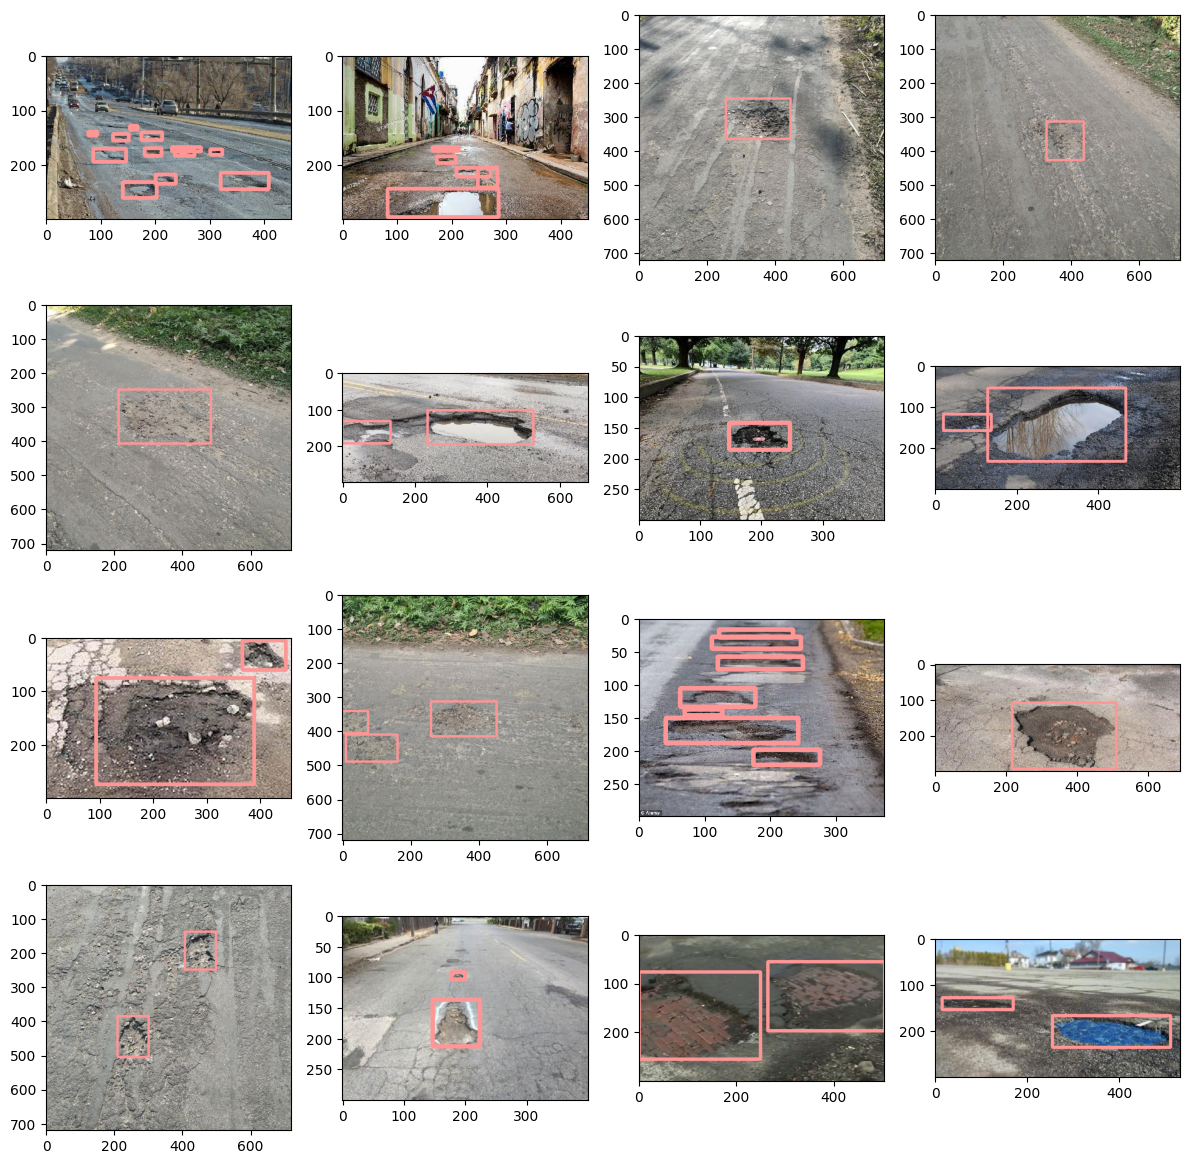

In [12]:
plot(train_dataset)

# Build Model

In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 59.7MB/s]


In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 5

In [16]:
model.to(device)
history = {'train': [], 'val': []}
for epoch in range(num_epochs):
  epoch_loss = 0.0
  for batch in train_loader:
    images = [data[0].to(device) for data in batch]
    targets = [{'boxes': data[1]['boxes'].to(device),
                'labels': data[1]['labels'].to(device)
                } for data in batch]
    loss_dict = model(images, targets)
    loss = sum(v for v in loss_dict.values())
    epoch_loss += loss.cpu().detach().numpy()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  epoch_loss /= len(train_loader)
  history['train'].append(epoch_loss)

  val_epoch_loss = 0.0
  for batch in val_loader:
    images = [data[0].to(device) for data in batch]
    targets = [{'boxes': data[1]['boxes'].to(device),
                'labels': data[1]['labels'].to(device)
                } for data in batch]
    with torch.no_grad():
      loss_dict = model(images, targets)
      loss = sum(v for v in loss_dict.values())
      val_epoch_loss += loss.cpu().detach().numpy()

  val_epoch_loss /= len(val_loader)
  history['val'].append(val_epoch_loss)

  print(f"Epoch {epoch+1}/{num_epochs}:    TrainLoss: {epoch_loss:.4f}  ValLoss: {val_epoch_loss}")

Epoch 1/5:    TrainLoss: 0.4639  ValLoss: 0.3975917539175819
Epoch 2/5:    TrainLoss: 0.3453  ValLoss: 0.32687586370636434
Epoch 3/5:    TrainLoss: 0.2944  ValLoss: 0.30229276155724244
Epoch 4/5:    TrainLoss: 0.2582  ValLoss: 0.29165279164033775
Epoch 5/5:    TrainLoss: 0.2364  ValLoss: 0.29074106233961444


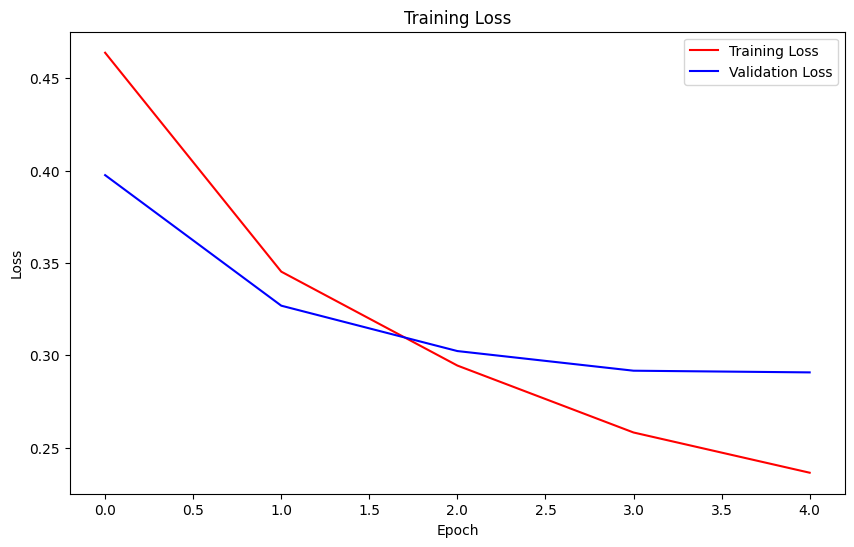

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(history["train"], label='Training Loss',color='r')
plt.plot(history["val"], label='Validation Loss',color='b')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Inference

In [ ]:
def filter_boxes_on_confidence(boxes, scores, conf=0.9, labels=None)->List[List[int]]:
    return boxes[scores>conf]

def visualize_inference(model, img: torch.Tensor|np.ndarray|str, conf = 0.9, device=None)->np.ndarray:
  if type(img)==str:
    img = cv2.imread(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if type(img)==np.ndarray:
     img_arr = img.copy()
     img_arr = np.transpose(img_arr, (2, 0, 1))/255
     img_arr = torch.unsqueeze(torch.from_numpy(img_arr), 0).type(torch.FloatTensor).to(device)
     img_arr = np.expand_dims(img_arr, 0)
  elif type(img)==torch.Tensor:
    img_arr = torch.unsqueeze(img, 0)

  if not device is None:
    img_arr.to(device)

  assert type(img_arr)==torch.Tensor, 'Image array must be tensor'
  output = model(img_arr)
  boxes = output[0]['boxes'].cpu().detach()
  labels = output[0]['labels'].cpu().detach()
  scores = output[0]['scores'].cpu().detach()
  boxes = filter_boxes_on_confidence(boxes, scores, conf=conf)
  img_op = plot_pascal_bboxes(img, boxes)
  return img_op

In [25]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

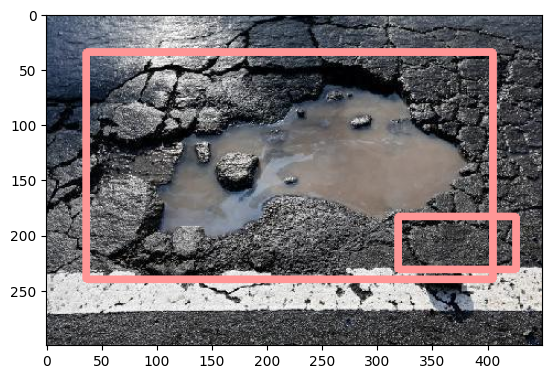

In [89]:
img, targets = val_dataset[5]
visualize_inference(model, img)

### Inference on Real-World Images

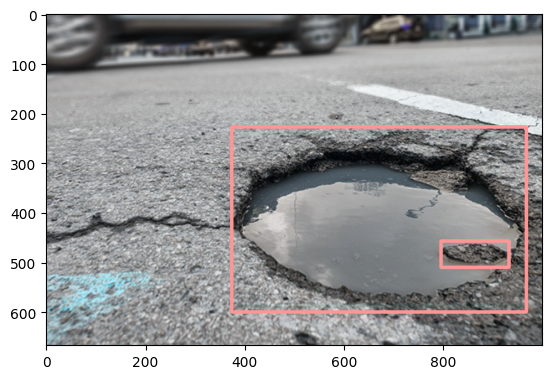

In [79]:
visualize_inference(model, '/content/pothole2.jpg')